In [1]:
# stavit da window size tj batch size ne bude bas 2 tjedna, ali ni samo 1 dan nego npr 7 dana ili manje

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import torch
import torch.nn as nn

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
torch.cuda.is_available()

True

In [4]:
first_train = pd.read_csv('CSV_files/train_one.csv',parse_dates=True,index_col='Date')
second_train = pd.read_csv('CSV_files/train_two.csv',parse_dates=True,index_col='Date')
third_train = pd.read_csv('CSV_files/train_three.csv',parse_dates=True,index_col='Date')

first_train.index.freq='H'
second_train.index.freq='H'
third_train.index.freq='H'

test = pd.read_csv('CSV_files/test.csv',parse_dates=True,index_col='Date')
test.index.freq='H'

C:\Users\Jose\anaconda3\envs\pytorchenv\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


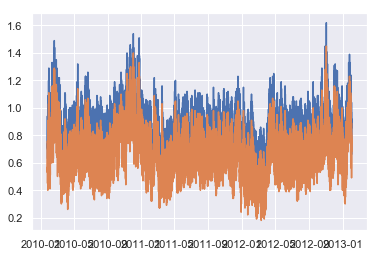

In [5]:
plt.plot(second_train['IOR'])
plt.plot(second_train['HHI_STLuka'])

In [6]:
len(second_train)

26459

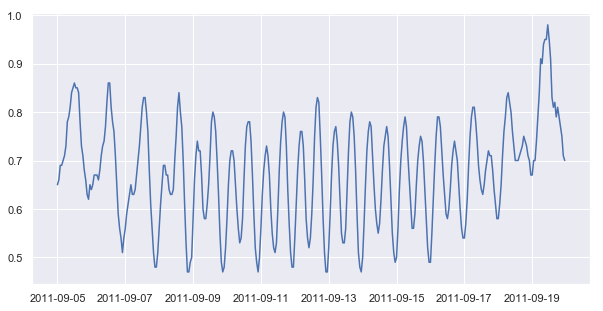

In [7]:
plt.figure(figsize=(10,5))
plt.plot(second_train['HHI_STLuka']['2011-09-05':'2011-09-19'])

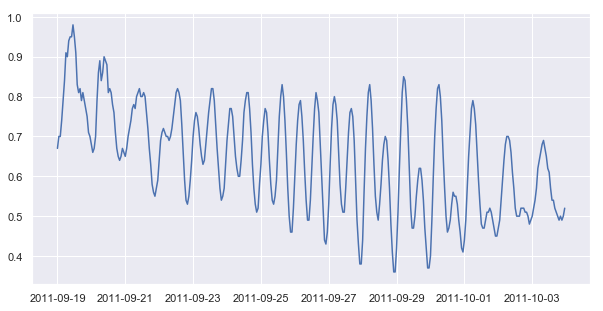

In [8]:
plt.figure(figsize=(10,5))
plt.plot(second_train['HHI_STLuka']['2011-09-19':'2011-10-03'])

#### nekakvo ponavljanje na dnevnoj bazi --> 24 retka

#### ponavljanje svakih cca 14 dana --> 14*24 retka

In [9]:
14*24

336

In [10]:
len(second_train)

26459

In [11]:
y = second_train['HHI_STLuka'].values.astype(float)

test_size = 24

train_set = y[:-test_size]
test_set = y[-test_size:]

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_set.reshape(-1,1))
train_norm = scaler.transform(train_set.reshape(-1,1))
train_norm = torch.FloatTensor(train_norm).cuda().view(-1)

In [13]:
#test_norm = scaler.transform(test_set.reshape(-1,1))

In [183]:
window_size = 48

In [184]:
def input_data(seq,ws):
    out = []
    L = len(seq)
    
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    
    return out

In [185]:
train_data = input_data(train_norm,window_size)

In [186]:
len(train_data)

26387

In [254]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size = 1,hidden_size = 50,output_size = 1):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm1 = nn.LSTM(input_size,hidden_size)
        
        self.linear1 = nn.Linear(hidden_size,output_size)
        
        #self.lstm2 = nn.LSTM(20,10)
        
        #self.linear2 = nn.Linear(10,output_size)
        
        self.hidden1 = (torch.zeros(1,1,self.hidden_size).cuda(),
                        torch.zeros(1,1,self.hidden_size).cuda())
        
        #self.hidden2 = (torch.zeros(1,1,10),
                        #torch.zeros(1,1,10))
        
        self.dropout1 = nn.Dropout(0.2)
        #self.dropout2 = nn.Dropout(0.3)
        
    def forward(self,seq):
        lstm_out1, self.hidden1 = self.lstm1(seq.view(len(seq),1,-1), self.hidden1)
        
        drop_output1 = self.dropout1(lstm_out1)
        
        drop_output1 = drop_output1.contiguous().view(-1,self.hidden_size)
        
        #pred = self.linear1(lstm_out1.view(len(seq),-1))
        
        pred = self.linear1(drop_output1)
        
        #lstm_out2, self.hidden2 = self.lstm2(pred.view(len(pred),1,-1), self.hidden2)
        
        #drop_output2 = self.dropout2(lstm_out2)
        
        #drop_output2 = drop_output2.contiguous().view(-1,10)
        
        #pred = self.linear2(drop_output2)
        
        #pred = self.linear2(lstm_out2.view(len(seq),-1))
        
        return pred[-1]

In [255]:
torch.manual_seed(101)

model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [256]:
model

LSTMnetwork(
  (lstm1): LSTM(1, 50)
  (linear1): Linear(in_features=50, out_features=1, bias=True)
  (dropout1): Dropout(p=0.2)
)

In [257]:
next(model.parameters()).is_cuda

False

In [258]:
gpumodel = model.cuda()

In [259]:
next(gpumodel.parameters()).is_cuda

True

In [260]:
epochs = 10
tl = []
import time

start_time = time.time()

#gpumodel.train()

for epoch in range(epochs):
    
    for seq,y_train in train_data:
        
        optimizer.zero_grad()
        
        model.hidden1 = (torch.zeros(1,1,model.hidden_size).cuda(),
                        torch.zeros(1,1,model.hidden_size).cuda())
        
#         model.hidden2 = (torch.zeros(1,1,10),
#                             torch.zeros(1,1,10))
        
        y_pred = gpumodel(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    
    
    
    future = 24

    preds = train_norm[-window_size:].tolist()

    #gpumodel.eval()

    for i in range(future):

        seq = torch.FloatTensor(preds[-window_size:]).cuda()
        
        #true_value = test_norm[i]

        with torch.no_grad():

            model.hidden1 = (torch.zeros(1,1,model.hidden_size).cuda(),
                            torch.zeros(1,1,model.hidden_size).cuda())
            
#             model.hidden2 = (torch.zeros(1,1,10),
#                             torch.zeros(1,1,10))
            

            preds.append(gpumodel(seq).item())
        
    true_preds = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1,1))
            
    loss_test = criterion(torch.FloatTensor(true_preds).view(-1).cuda(),torch.FloatTensor(y[-test_size:]).cuda())
            
    tl.append(loss_test)
            
    print(f'Epoch {epoch} Loss {loss.item()} Loss_test {loss_test.item()}')
    
    
    
total_time = time.time()-start_time
print(total_time/60)

Epoch 0 Loss 1.594209493305243e-06 Loss_test 0.01740151084959507
Epoch 1 Loss 0.0006876709521748126 Loss_test 0.015742069110274315
Epoch 2 Loss 0.001873610308393836 Loss_test 0.008748655207455158
Epoch 3 Loss 0.0006676170160062611 Loss_test 0.016582971438765526
Epoch 4 Loss 9.62677768256981e-06 Loss_test 0.018416056409478188
Epoch 5 Loss 1.0217518138233572e-05 Loss_test 0.01756107062101364
Epoch 6 Loss 0.0008385204710066319 Loss_test 0.013419228605926037
Epoch 7 Loss 0.0016796935815364122 Loss_test 0.016564609482884407
Epoch 8 Loss 0.0011954811634495854 Loss_test 0.008236818946897984
Epoch 9 Loss 0.0005269060493446887 Loss_test 0.026083676144480705
30.960690780480704


In [261]:
# ws = 24, ep = 10, hl = 1, hn = 100 ----> final test error 0.57 ---> dosta razdvojeni grafovi
# ws = 24, ep = 10, hl = 1, hn = 200 ----> final test error 0.48 --> isto ko i gore
# ws = 24, ep = 10, hl = 1, hn = 300 ----> final test error 0.57 ---> ista stvar

In [262]:

#loss za cili epoch a ne samo zadnji batch triba napravit!!

In [263]:
# povecat batch size mozda --> vidit sliku

In [264]:
torch.FloatTensor([4]).view(-1)

tensor([4.])

In [265]:
future = 24

preds = train_norm[-window_size:].tolist()

gpumodel.eval()

for i in range(future):
    
    seq = torch.FloatTensor(preds[-window_size:]).cuda()
    
    with torch.no_grad():
        
        model.hidden1 = (torch.zeros(1,1,model.hidden_size).cuda(),
                        torch.zeros(1,1,model.hidden_size).cuda())
            
        preds.append(gpumodel(seq).item())


In [266]:
len(preds)

72

In [267]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1,1))

In [268]:
criterion(torch.FloatTensor(true_predictions).view(-1).cuda(),torch.FloatTensor(y[-test_size:]).cuda())

tensor(0.0203, device='cuda:0')

In [269]:
df_true_vs_pred = second_train[-future:].drop(['YYYY','MM','DD','HH','IOR'], axis=1)
df_true_vs_pred['Predicted'] = true_predictions

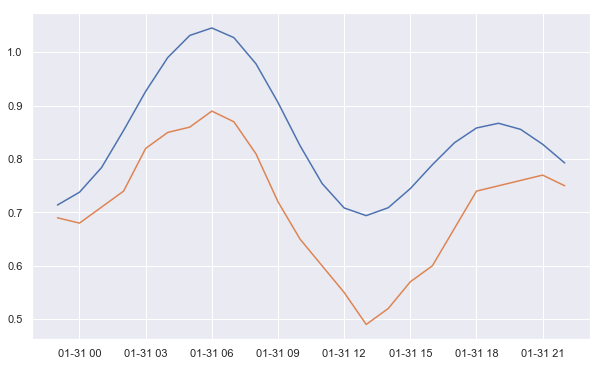

In [270]:
plt.figure(figsize=(10,6))
plt.plot(df_true_vs_pred['Predicted'])
plt.plot(df_true_vs_pred['HHI_STLuka'])

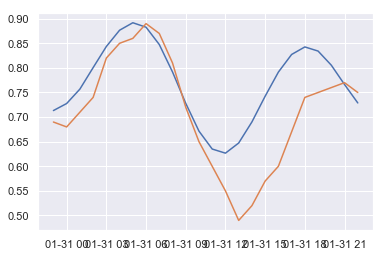

In [35]:
len(df_true_vs_pred)

24

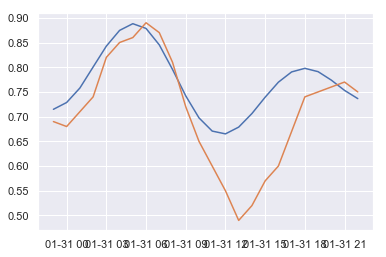

In [24]:
Epoch 0 Loss 0.017087101936340332 Loss_test 0.04020043462514877
Epoch 1 Loss 0.0028188377618789673 Loss_test 0.03217434138059616
Epoch 2 Loss 0.011405736207962036 Loss_test 0.04510781913995743
Epoch 3 Loss 0.0016736090183258057 Loss_test 0.014443017542362213
Epoch 4 Loss 0.009603336453437805 Loss_test 0.05674172192811966
Epoch 5 Loss 0.00442495197057724 Loss_test 0.048707760870456696
Epoch 6 Loss 0.003760814666748047 Loss_test 0.059509314596652985
Epoch 7 Loss 0.004099033772945404 Loss_test 0.018176890909671783
Epoch 8 Loss 0.0017253756523132324 Loss_test 0.02453906089067459
Epoch 9 Loss 0.007426783442497253 Loss_test 0.02358030527830124

In [155]:
from sklearn.metrics import mean_squared_error

In [186]:
np.sqrt(mean_squared_error(true_predictions, df_true_vs_pred['HHI_STLuka'].values.astype(float)))

0.14280823231423562